# Online learning

In this notebook we are providing an example on how to use the Bayesian framework for inference using an online fashion. We show that, in order to train on a data stream, we do not need to store all data but the parameters of the posterior at each iteration update.

In [1]:
import os

import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

from IPython.display import Video

from dataclasses import dataclass

# Use case: classic toin coss

We want to estimate the probability of getting heads for a specific coin. At each iteration we will flip the coin $n$ times and update the posterior probability. We will be using a fake coin that produces heads around 20% of the times.

The likelihood of each iteration is a Binomial distribution. Given that, for discrete outcomes, the beta distribution is a conjugate of the Binomial likelihood, the posterior is also a Beta distribution. We use the posterior of one iteration as the prior of the next one.

## Summary

- Prior $P(\theta) = P(p) \sim Beta(a, b)$
- Likelihood $P(X|\theta) = P(X|p) \sim Binomial(n, k, p)$
- Posterior $P(\theta|X) = P(p|X) \sim Beta(a', b')$

Given the outcomes of $i$th experiment $X_i = \{x_1, x_2, \ldots, x_n\}$, the parameters of the posterior $a'$, $b'$ are calculated as:

$$
\begin{align*}
a' & = a + \sum x_i \\
b' & = b + n - \sum x_i
\end{align*}
$$

More information in the conjugate prior table in the [Wikipedia page](https://en.wikipedia.org/wiki/Conjugate_prior).

## Define groundtruth values and parameters

In [2]:
@dataclass
class Beta:
    
    alpha: float
    beta: float

real_p = 0.20

samples_per_step = 10

# Assume coin is fair
initial_prior_params = Beta(alpha=2, beta=2)

## Implement coin toss logic

In [3]:
@dataclass
class Tosses:
    
    values: np.ndarray
    
    @staticmethod
    def sample(p: float, n: int) -> np.ndarray:
        return Tosses(
            values=scipy.stats.bernoulli.rvs(p=p, size=n)
        )

    def heads(self) -> int:
        return (self.values == 1).sum()
    
    def tails(self) -> int:
        return (self.values == 0).sum()

# Simulate

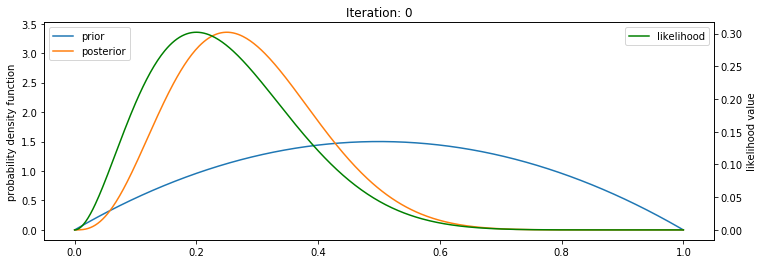

In [6]:
N_TRIALS = 250

# Init plot
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
ax2 = ax.twinx()
xs = np.linspace(0, 1, 500)


def animate(data: callable,
            fig) -> None:

    prior_fn, posterior_fn, likelihood_fn, i = data
   
    ax.clear()
    ax.plot(xs, prior_fn(xs), label='prior')
    ax.plot(xs, posterior_fn(xs), label='posterior')
    ax.set_ylabel('probability density function')
    
    # Show likelihood in another axis (since it is not a prob dist)
    ax2.clear()
    ax2.plot(xs, likelihood_fn(xs), label='likelihood', color='green')
    ax2.set_ylabel('likelihood value')
    
    # Show legend and title
    ax.legend(loc=2)
    ax2.legend(loc=1)
    ax.set_title(f'Iteration: {i}')


def trial():
    
    for i in range(N_TRIALS):
    
        if i == 0:
            prior_params = initial_prior_params
        else:
            prior_params = posterior_params

        # Get new observation
        tosses = Tosses.sample(n=samples_per_step, p=real_p)

        # Define Beta prior using parameters
        prior_fn = scipy.stats.beta(a=prior_params.alpha,
                                    b=prior_params.beta).pdf

        # Likelihodd as PMF of binomial given data
        likelihood_fn = lambda p: \
            scipy.stats.binom.pmf(n=samples_per_step, k=tosses.heads(), p=p)

        # Posterior is Beta as Beta is the conjugate of the Binomial
        posterior_params = Beta(alpha=tosses.heads() + prior_params.alpha,
                                beta=tosses.tails() + prior_params.beta)
        posterior_fn = scipy.stats.beta(a=posterior_params.alpha,
                                        b=posterior_params.beta).pdf

        # Generate plot for current step
        yield prior_fn, posterior_fn, likelihood_fn, i


animation_path = os.path.join('media', 'conjugates.mp4')

# Create animation if does not exist
if not os.path.isfile(animation_path):
 
    ani = animation.FuncAnimation(fig,
                                  animate,
                                  trial,
                                  interval=50,
                                  save_count=N_TRIALS,
                                  fargs=(fig, ))

    ani.save(animation_path, fps=10, extra_args=['-vcodec', 'libx264'])

In [7]:
# Display animation
Video(animation_path)

We see the posterior probability successively approaches to the real value of $0.20$.